In [1]:
%matplotlib inline
from __future__ import division
import om10,os
import numpy as np
import matplotlib.pyplot as plt
import triangle

In [2]:
# redshift sigma g/Reff r   i   z     g mag   r mag    i mag  z    w1     w2       w3      w4
lrgs = np.loadtxt(os.path.expandvars('$OM10_DIR/data/LRGo.txt'))

#kill photometric outliers in r and i bands
lrgs = lrgs[np.logical_and(lrgs[:,8]<24,lrgs[:,9]<22)] 
#color outliers:
lrgs = lrgs[(lrgs[:,6] - lrgs[:,7]) < 3] 
lrgs = lrgs[(lrgs[:,7] - lrgs[:,8]) > 0]
lrgs = lrgs[(lrgs[:,8] - lrgs[:,9]) > 0]

#redshift       g    r    i    z     w1      w2       w3     w4
qsos = np.loadtxt(os.path.expandvars('$OM10_DIR/data/QSOo.txt'))
qsos = qsos[np.logical_and(qsos[:,3]>0,qsos[:,1]>0)] #require g and i band > 0 to kill -10,000 outliers

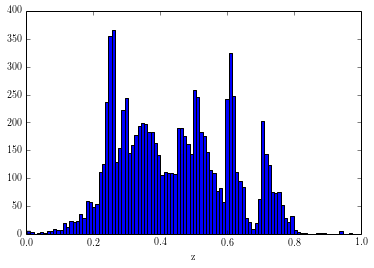

In [3]:
_ = plt.hist(lrgs[:,0].flatten(),bins=100)
plt.xlabel('z')

Well, we don't have that great a handle on redshifts past .8, but hopefully ok...

##PS1QLS Forecast

In [4]:
#load and decorate OM10 catalog
db = om10.DB(catalog='$OM10_DIR/data/qso_mock.fits')
db.get_sky_positions(input_cat='$OM10_DIR/data/CFHTLS_LRGs.txt')
db.assign_sky_positions()
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

#PS1-like sample!
db.select_random(maglim=21.4,area=100000.0,IQ=1.0)
print 'Total number of sims: ', len(db.sample)

#which objects got correctly colored in our desired parameter range?
matched = db.sample[db.sample['ZLENS'] < 3]
#matched = matched[matched['ZLENS'] < 3]
matched = matched[np.logical_and(matched['SDSS_FLAG_SRC'] == 0,matched['SDSS_FLAG_LENS'] == 0)]
matched = matched[matched['ZSRC'] < 4.5]
matched = matched[np.logical_and(matched['VELDISP'] > 200,matched['VELDISP'] < 300)]
print 'Fraction remaining after bad color matching: ', len(matched)/len(db.sample)

#more restrictive range that improves color matching
matched = matched[matched['ZLENS'] < .98]
print 'Fraction remaining after good color matching: ', len(matched)/len(db.sample)

#which objects got assigned a position?
#matched = db.sample[np.logical_and(db.sample['RA']> 0,db.sample['DEC'] > -20)]
matched = matched[np.logical_and(matched['RA']> 0,matched['DEC'] > -20)]
print 'Fraction remaining after position-matching: ', len(matched)/len(db.sample)

om10.DB: read in LRG sky position data from  /Users/mbaumer/pybin/OM10/data/CFHTLS_LRGs.txt
Mean LRG RA,DEC,z,i =  34.3807307408 -7.09643979181 0.612498 21.63331883
om10.DB: number of LRGs stored =  10000
om10.DB: selection yields  3317  lenses
Total number of sims:  3317
Fraction remaining after bad color matching:  0.639433222792
Fraction remaining after good color matching:  0.462767561049
Fraction remaining after position-matching:  0.358757913778


Going from ZLENS < 3 to ZLENS < 1 costs us 9% of our training set, but I think will greatly improve our ability to apply XD to this problem, because otherwise, there will be massive color peaks in the lens color distributions. The fixes Adri suggested are good, but I propose we save them for pass 2...

So the final prediction is that there would be 379 lenses that we could hope to find in our PS1QLS sample!

In [40]:
len(matched) #total number of systems in input cat!

1186

In [34]:
db.sample = matched
out_cat = db.make_sim_input_catalog()

In [35]:
out_cat

LENSID,RA,DEC,...,I,Z
5810316.0,34.64855907,-7.843399404,...,19.71678,19.24147
5810316.0,34.6483635464,-7.84380984844,...,19.0536446231,18.8341046231
5810316.0,34.6486285253,-7.84323284844,...,19.2523156858,19.0327756858
22039442.0,34.43273733,-5.827326791,...,18.10475,17.63566
22039442.0,34.4327503696,-5.82756665211,...,17.3395530978,17.4058530978
22039442.0,34.4325370171,-5.82731473544,...,17.428126562,17.494426562
22039442.0,34.4329389553,-5.82727356878,...,17.3496676602,17.4159676602
22039442.0,34.4327466839,-5.82709956878,...,17.0425030211,17.1088030211
26594724.0,34.1184052,-5.921554115,...,19.43255,18.65366
26594724.0,34.1183392928,-5.92165592056,...,17.4550846011,17.4802646011


In [38]:
out_cat.write('input_cat_for_eric.fits',format='fits',overwrite=True)

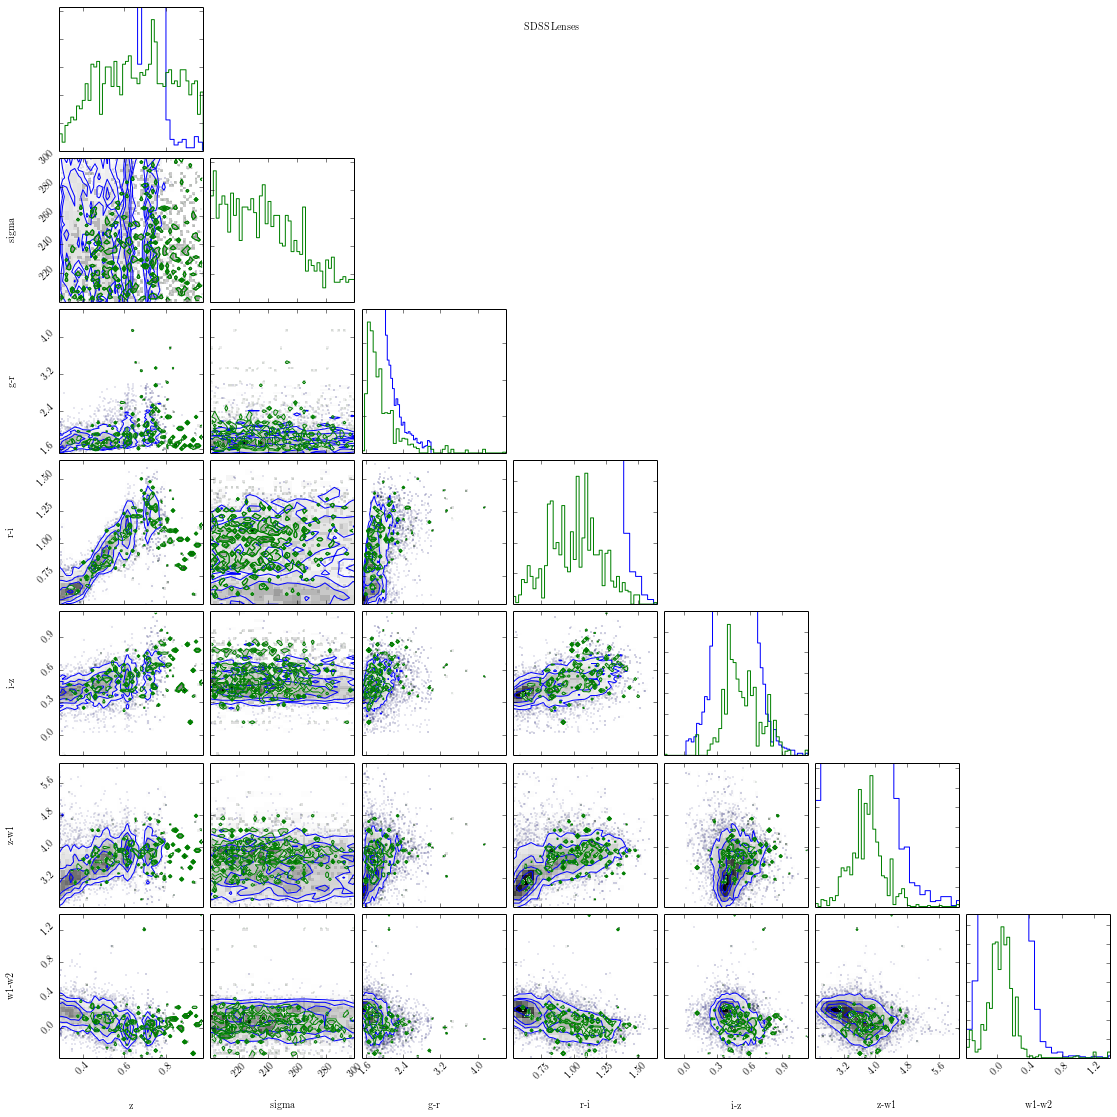

In [9]:
to_plot = np.array([lrgs[:,0], lrgs[:,1], lrgs[:,6]-lrgs[:,7], lrgs[:,7]-lrgs[:,8],\
                    lrgs[:,8]-lrgs[:,9], lrgs[:,9]-lrgs[:,10], lrgs[:,10]-lrgs[:,11]]).transpose()
painted_lenses = np.array([matched['ZLENS'],matched['VELDISP'],matched['MAGG_LENS']-matched['MAGR_LENS'], \
                    matched['MAGR_LENS']-matched['MAGI_LENS'],matched['MAGI_LENS']-matched['MAGZ_LENS'], \
                    matched['MAGZ_LENS']-matched['MAGW1_LENS'],matched['MAGW1_LENS']-matched['MAGW2_LENS']]).transpose()
fig = triangle.corner(to_plot,labels=['z','sigma','g-r','r-i','i-z','z-w1','w1-w2'],color='Blue')
_ = triangle.corner(painted_lenses,labels=['z','sigma','g-r','r-i','i-z','z-w1','w1-w2'],color='Green',fig=fig)
plt.suptitle('SDSS Lenses')

Colors look reasonable--two populations because input catalog has both lenses and sources...